In [1]:
import gym
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
tf.disable_v2_behavior()

W0728 21:36:11.291670 43884 deprecation.py:323] From c:\users\gwanmo park\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\compat\v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def one_hot(x, n):
    return np.identity(n)[x:x+1]

In [5]:
def Q_learn(env_id, learning_rate=0.1, discount_rate=0.99, num_episodes=2000):
    env = gym.make(env_id)
    if env_id == 'CartPole-v0':
        input_size = env.observation_space.shape[0]
    else:
        input_size = env.observation_space.n
    output_size = env.action_space.n
    
    X = tf.placeholder(shape=[None, input_size], dtype=tf.float32)
    W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))
    
    Qpred = tf.matmul(X, W)
    Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)
    
    loss = tf.reduce_sum(tf.square(Y-Qpred))
    
    train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
#     train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    rList = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(num_episodes):
            s = env.reset()
            e = 1. / ((i/50) + 10)
            rAll = 0
            done = False
            steps = 0
            
            while not done:
                steps += 1
                if env_id == "CartPole-v0":
                    x = np.reshape(s, [1, input_size])
                    Qs = sess.run(Qpred, feed_dict={X: x})
                else:
                    Qs = sess.run(Qpred, feed_dict={X: one_hot(s, input_size)})
                    
                if np.random.rand(1) < e:
                    a = env.action_space.sample()
                else:
                    a = np.argmax(Qs)
                
                s1, reward, done, _ = env.step(a)
                if done:
                    if env_id == 'CartPole-v0':
                        Qs[0, a] = -100
                    else:
                        Qs[0, a] = reward
                else:
                    if env_id == "CartPole-v0":
                        x1 = np.reshape(s, [1, input_size])
                        Qs1 = sess.run(Qpred, feed_dict={X: x1})
                    else:
                        Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1, input_size)})
                    Qs[0, a] = reward + discount_rate * np.max(Qs1)
                
                if env_id == 'CartPole-v0':
                    sess.run(train, feed_dict={X: x, Y:Qs})
                else:
                    sess.run(train, feed_dict={X: one_hot(s, input_size), Y: Qs})
                
                rAll += reward
                s = s1
            if env_id == 'CartPole-v0':
                rList.append(steps)
                if len(rList) > 10 and np.mean(rList[-10:]) > 500:
                    break
            else:
                rList.append(rAll)
    
    print("Success rate: " + str(sum(rList)/num_episodes))
    plt.bar(range(len(rList)), rList, color='blue')
    plt.show()

Success rate: 0.4565


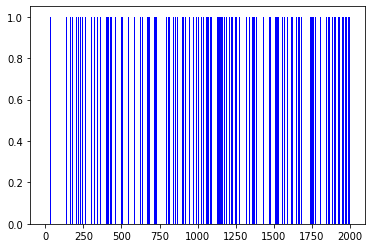

In [6]:
Q_learn('FrozenLake-v0')

Success rate: 31.216


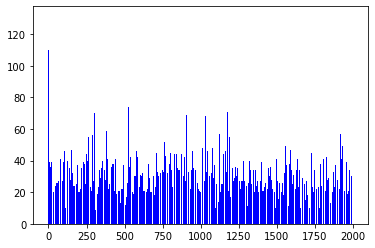

In [7]:
Q_learn('CartPole-v0')

In [4]:
import tensorflow as tf

In [46]:
def Q_learn_tf2(env_id, learning_rate=0.1, discount_rate=0.99, num_episodes=2000):
    env = gym.make(env_id)
    input_size = env.observation_space.n
    output_size = env.action_space.n
    
    W = tf.Variable(tf.random.uniform(shape=(input_size, output_size), minval=0, maxval=0.01, dtype=tf.dtypes.float64))
    
    @tf.function
    def Qpred(x, W):
        return tf.matmul(x, W)
    
    def loss_fn(Y, Qpred):
        return tf.reduce_sum(tf.square(Y-Qpred))
    
    optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
    
    rList = []
    for i in range(num_episodes):
        s = env.reset()
        e = 1. / ((i/50) + 10)
        rAll = 0
        done = False
        local_loss = []
        
        while not done:
            Qs = Qpred(one_hot(s, input_size), W).numpy()
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)
            
            s1, reward, done, _ = env.step(a)
            if done:
                Qs[0, a] = reward
            else:
                Qs1 = Qpred(one_hot(s1, input_size), W)
                Qs[0, a] = reward + discount_rate * np.max(Qs1)
            
            with tf.GradientTape() as tape:
                loss = loss_fn(Qs1, tf.convert_to_tensor(Qs))
            gradient = tape.gradient(loss, [W])
            optimizer.apply_gradients(zip(gradient, [W]))
            
            rAll += reward
            s = s1
        rList.append(rAll)
    print("Success rate: " + str(sum(rList)/num_episodes))
    plt.bar(range(len(rList)), rList, color='blue')
    plt.show()

In [242]:
def taxi_feature(state, action, env):
    MAP = np.asarray([\
    "+---------+",\
    "|R: | : :G|",\
    "| : : : : |",\
    "| : : : : |",\
    "| | : | : |",\
    "|Y| : |B: |",\
    "+---------+",\
], dtype='c')
    features = []
    
    locs = [(0,0), (0,4), (4,0), (4,3)]
    taxi_row, taxi_col, passenger_idx, dest_idx = list(env.decode(state))
    
    taxi_loc = np.array([taxi_row, taxi_col])
    wall = 0
    if action == 0: #South
        wall = 1 if taxi_row == 4 else 0
        taxi_loc[0] = min(taxi_loc[0]+1, 4)
    elif action == 1: #North
        wall = 1 if taxi_row == 0 else 0
        taxi_loc[0] = max(taxi_loc[0]-1, 0)
    elif action == 2: #East
        if MAP[1+taxi_row, 2*taxi_col + 2] == b":":
            taxi_loc[1] = min(taxi_loc[1]+1, 4)
        else:
            wall = 1
    elif action == 3: #West
        if MAP[1+taxi_row, 2*taxi_col] == b":":
            taxi_loc[1] = max(taxi_loc[1]-1, 0)
        else:
            wall = 1
            
    features.append(wall)
        
    passenger_loc = np.array(locs[passenger_idx]) if passenger_idx != 4 else taxi_loc
    dest_loc = np.array(locs[dest_idx])
    
    with_passenger = 1 if passenger_idx == 4 else 0
        
    illegal = 0
    done = 0
    if action == 4:
        if passenger_idx != 4 and (taxi_row, taxi_col) == locs[passenger_idx]:
            with_passenger = 1
            illegal = 0
        else:
            illegal = 1
    if action == 5:
        if (taxi_row, taxi_col) == locs[dest_idx] and passenger_idx == 4:
            with_passenger = 0
            illegal = 0
            done = 1
        elif (taxi_row, taxi_col) in locs and passenger_idx == 4:
            with_passenger = 0
            illegal = 0
        else:
            illegal = 1
    
    features.append(done)
    features.append(with_passenger)
    features.append(illegal)
    
    if with_passenger:
        dist_to_passenger = 0
    else:
        dist_to_passenger = np.sum(np.abs(taxi_loc - passenger_loc))
    inv_dist_to_p = 1 / dist_to_passenger**2 if dist_to_passenger != 0 else 2
    
#     features.append(inv_dist_to_p)
        
    dist_to_dest = np.sum(np.abs(taxi_loc - dest_loc))
    inv_dist_to_d = 1 / dist_to_dest**2 if dist_to_dest != 0 else 2
    
#     features.append(inv_dist_to_d)
    
    if with_passenger:
        expected_dist = dist_to_dest
    else:
        expected_dist = dist_to_passenger + np.sum(np.abs(passenger_loc - dest_loc))
    inv_exp_d = 1 / expected_dist**2 if expected_dist != 0 else 2
    
    if action == 4 or action == 5:
        inv_exp_d = 0
    
    features.append(inv_exp_d)
    
    return np.array(features)

In [243]:
taxi_feature(45, 1, gym.make('Taxi-v2'))

array([1.  , 0.  , 0.  , 0.  , 0.25])

In [258]:
def Q_learn_feature(env_id, feature_func, learning_rate=0.05, discount_rate=0.99, num_episodes=2000):
    env = gym.make(env_id)
    w = np.random.rand(feature_func(0, 0, env).shape[0])
    def Q(w, f):
        return np.dot(w, f)
    rList = []
    for i in range(num_episodes):
        cur_state = env.reset()
        rAll = 0
        done = False
        
        while not done:
            if np.random.rand(1) < (1./(i//50 + 10)):
                action = env.action_space.sample()
            else:
                action = np.argmax([Q(w, feature_func(cur_state, a, env)) for a in range(env.action_space.n)])
                    
            new_state, reward, done, _ = env.step(action)
            
            diff = reward + discount_rate * np.max([Q(w, feature_func(new_state, a, env)) \
                                                    for a in range(env.action_space.n)])  \
                                - Q(w, feature_func(cur_state, action, env))
            w += learning_rate * diff * feature_func(cur_state, action, env)
            
            rAll += reward
            cur_state = new_state
#         print(rAll)
#         print(w)
        rList.append(rAll)
    print("Average score: " + str(sum(rList)/num_episodes))
    print("Final Weights")
    print(w)
    plt.plot(range(len(rList)), rList, color='blue')
    plt.show()
    return rList

Average score: -103.3875
Final Weights
[-7.10510575e-01  1.48897923e+03  2.20399411e+01 -9.61906067e+00
 -5.12562366e+01]


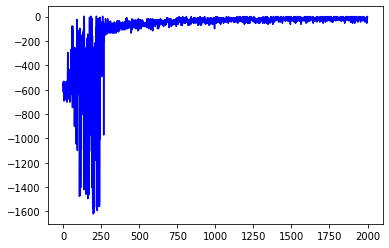

In [253]:
r = Q_learn_feature('Taxi-v2', taxi_feature, learning_rate = 0.03, num_episodes = 2000)

In [208]:
def play(env_id, feature_func, w):
    env = gym.make(env_id)
    cur_state = env.reset()
    env.render()
    done = False
    def Q(w, f):
        return np.dot(w, f)
    while not done:
        action = np.argmax([Q(w, feature_func(cur_state, a, env)) for a in range(env.action_space.n)])
        new_state, reward, done, _ = env.step(action)
        for a in range(env.action_space.n):
            print(feature_func(cur_state, a, env))
        env.render()
        cur_state = new_state